In [28]:
import polaris as po
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
from stepmix.stepmix import StepMix

competition = po.load_competition(f"asap-discovery/antiviral-admet-2025")

[2025-02-05 15:41:00] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=975390;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=976034;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.5).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=568326;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=345520;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/polaris/dataset/_base.py#182\182]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

In [ ]:
train, test = competition.get_train_test_split()

In [101]:
competition.model_config

{'alias_generator': <function pydantic.alias_generators.to_camel(snake: str) -> str>,
 'populate_by_name': True,
 'arbitrary_types_allowed': True}

# Number of missing

In [42]:
df = train.as_dataframe()
for col in df.columns.difference(['CXSMILES']): 
    df[f'isna-{col}'] = df[col].isna()

for i in [3, 4, 5, 6, 7]:
    model = StepMix(n_components=i, measurement='binary', verbose=0, random_state=42)
    model.fit(df.filter(regex='^isna'))


    df[f'class_n{i}'] = model.predict(df.filter(regex='^isna'))
# sk.cluster.KMeans()

# sns.heatmap(y_vals.isna(),  square=False, cbar=False)

/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 31.00it/s, max_LL=-843, max_avg_LL=-1.94]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/roberta

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  5.87it/s, max_LL=-838, max_avg_LL=-1.93]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/roberta

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  3.75it/s, max_LL=-836, max_avg_LL=-1.93]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/roberta

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, max_LL=-836, max_avg_LL=-1.93]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/roberta

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  3.53it/s, max_LL=-833, max_avg_LL=-1.92]
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/stepmix/stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/robertarbon/mamba/envs/polaris/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

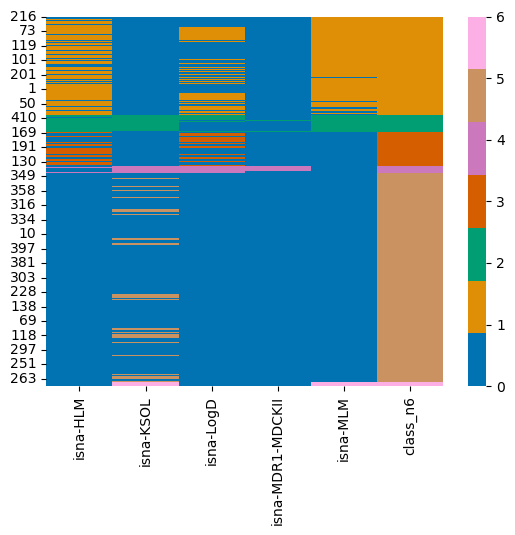

In [85]:
n_clusters = 6
ccol = f"class_n{n_clusters}"
to_plot = df.filter(regex=f'(^isna)|({ccol})').copy()

to_plot = to_plot.sort_values(by=ccol, ascending=True)
to_plot[ccol] += 1

for col in to_plot.columns.difference([ccol]):
    to_plot[col] = to_plot.apply(lambda x: {True: x[ccol],False: 0}[x[col]], axis=1)



sns.heatmap(to_plot, cmap=sns.color_palette('colorblind', n_clusters+1),  square=False, cbar=True)

In [6]:
df = train.as_dataframe()

n_missing_per_mol = df[df.columns.difference(['CXSMILES'])].isna().sum(axis=1)

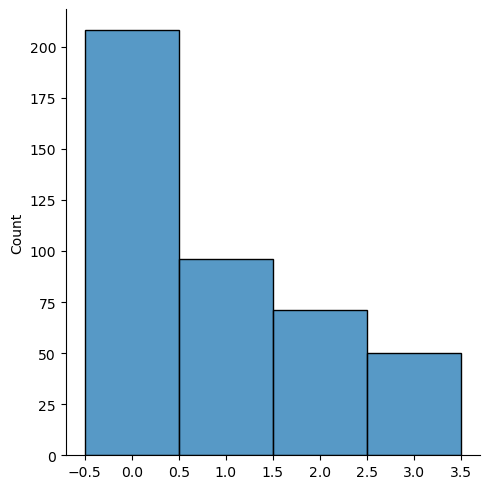

In [7]:
sns.displot(n_missing_per_mol, bins=np.array([0, 1, 2, 3, 4])-0.5)

# Predicting the missing
Given the very different scales of the end points, and the fact that LogD is on a log scale, it makes sense to scale the inputs and apply a log+1 transform. Then we can use the values as predictors for the missing values. 

In [14]:
min_val, max_val = np.exp(df.LogD.min()), np.exp(df.LogD.max())
min_val, max_val

(0.4965853037914095, 90.01713130052181)

Init signature:
sk.preprocessing.MinMaxScaler(
    feature_range=(0, 1),
    *,
    copy=True,
    clip=False,
)
Docstring:     
Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such
that it is in the given range on the training set, e.g. between
zero and one.

The transformation is given by::

    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min

where min, max = feature_range.

This transformation is often used as an alternative to zero mean,
unit variance scaling.

`MinMaxScaler` doesn't reduce the effect of outliers, but it linearly
scales them down into a fixed range, where the largest occurring data point
corresponds to the maximum value and the smallest one corresponds to the
minimum value. For an example visualization, refer to :ref:`Compare
MinMaxScaler with other scalers <plot_all_scaling_minmax_scaler_section>`.

Read more in the :ref:`User Guide 

In [1]:
import datamol as dm
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer